# 第4部　Box-Jenkins法とその周辺

## 第3章　SARIMAXモデル

### 分析の準備

In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd
from scipy import stats

# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

# グラフの日本語表記
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Meiryo'

In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option('display.width', 80)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

### 和分過程と季節和分過程

#### シミュレーションデータの作成

In [3]:
# 乱数の種
np.random.seed(1)

# 正規分布に従う乱数の累積和を作成し、ランダムウォーク系列を作る
sim_size = 100
rw = np.cumsum(stats.norm.rvs(loc=0, scale=1, size=sim_size))

In [4]:
# 乱数の種
np.random.seed(1)

srw = np.zeros(sim_size)
np.put(srw, [0,1,2,3], stats.norm.rvs(loc=0, scale=1, size=4))

for i in range(4, sim_size):
    np.put(srw, i, srw[i - 4] + stats.norm.rvs(loc=0, scale=1, size=1))

#### ランダムウォーク過程と季節ランダムウォーク過程の比較

array([<Axes: >, <Axes: >], dtype=object)

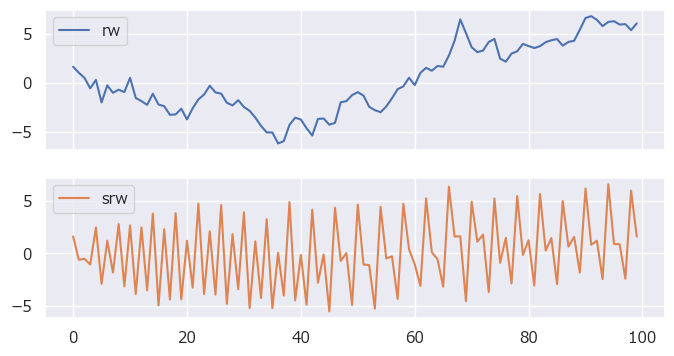

In [5]:
# DataFrameにまとめる
rw_df = pd.DataFrame({
    'rw':rw, 'srw':srw
})

# 可視化
rw_df.plot(subplots=True)

array([<Axes: >, <Axes: >], dtype=object)

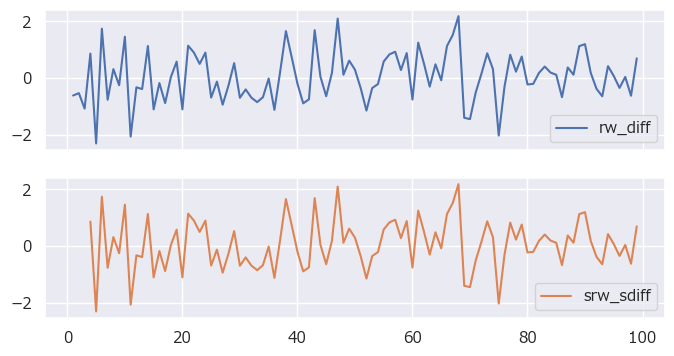

In [6]:
# ランダムウォーク過程の1階差分系列
rw_df['rw_diff'] = rw_df.diff(1).rw

# 季節ランダムウォーク過程の季節差分系列
rw_df['srw_sdiff'] = rw_df.diff(4).srw

# 可視化
rw_df[['rw_diff', 'srw_sdiff']].plot(subplots=True)

#### 季節ランダムウォーク過程の累積和

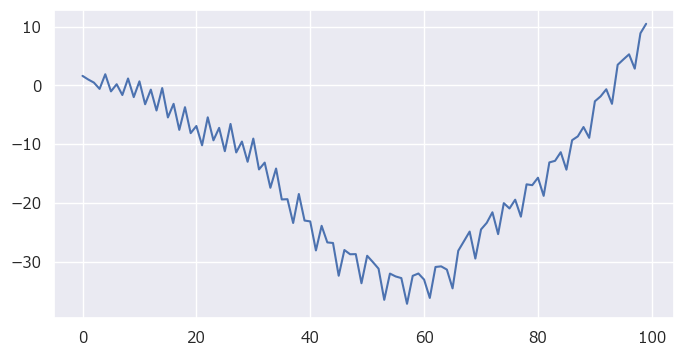

In [7]:
# 季節ランダムウォーク過程に対して、さらに累積和をとる
strw = rw_df['srw'].cumsum()

# 可視化
plt.plot(strw)

### SARIMAモデルの推定と予測

#### データの読み込み

In [8]:
# 飛行機乗客数データの読み込み
air_passengers = sm.datasets.get_rdataset("AirPassengers").data

# 日付インデックスの作成
air_passengers.index = pd.date_range(
    start='1949-01-01', periods=len(air_passengers), freq='MS')

# 不要な時間ラベルの削除
air_passengers = air_passengers.drop(air_passengers.columns[0], axis=1)

# 訓練データとテストデータに分割する
train = air_passengers.loc['1949-01':'1957-12']
test =  air_passengers.loc['1958-01':'1960-12']

#### 飛行機乗客数データに対するSARIMAモデルの適用

In [9]:
mod_sarima = tsa.SARIMAX(
    train, order=(3, 1, 2), seasonal_order=(1, 1, 1, 12)
).fit(maxiter=1000)

print(mod_sarima.params)

ar.L1        0.490087
ar.L2        0.323658
ar.L3       -0.145460
ma.L1       -0.750357
ma.L2       -0.161098
ar.S.L12    -0.251575
ma.S.L12     0.110758
sigma2      84.290726
dtype: float64


In [10]:
# 参考：
print(mod_sarima.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                value   No. Observations:                  108
Model:             SARIMAX(3, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -345.888
Date:                              Wed, 11 Sep 2024   AIC                            707.775
Time:                                      16:46:00   BIC                            728.206
Sample:                                  01-01-1949   HQIC                           716.031
                                       - 12-01-1957                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4901      0.712      0.689      0.491      -0.904       1.885
ar.L2          0.32

In [11]:
# ほかのソフトウェアと近い方法にする
print(
    tsa.SARIMAX(train, order=(3, 1, 2), 
                seasonal_order=(1, 1, 1, 12), trend='n',
                simple_differencing=True,
                hamilton_representation=True
               ).fit(cov_type='approx', maxiter=10000, method='nm').summary()
)

Optimization terminated successfully.
         Current function value: 3.640928
         Iterations: 1267
         Function evaluations: 1819
                                      SARIMAX Results                                       
Dep. Variable:                         D.DS12.value   No. Observations:                   95
Model:             SARIMAX(3, 0, 2)x(1, 0, [1], 12)   Log Likelihood                -345.888
Date:                              Wed, 11 Sep 2024   AIC                            707.776
Time:                                      16:46:01   BIC                            728.207
Sample:                                  02-01-1950   HQIC                           716.032
                                       - 12-01-1957                                         
Covariance Type:                             approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

#### SARIMAモデルによる予測

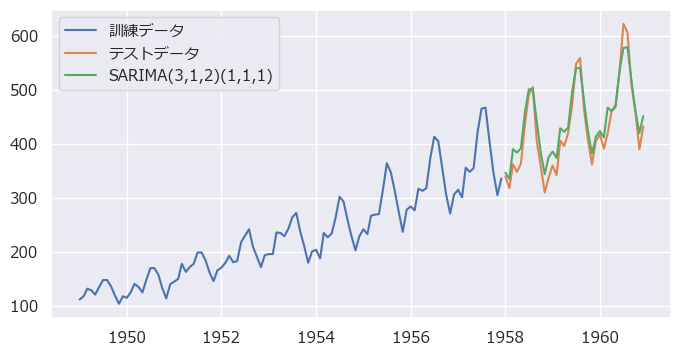

In [12]:
# 予測
pred_sarima = mod_sarima.forecast(36)

# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 4))

# 飛行機乗客数の折れ線グラフ
ax.plot(train['value'], label='訓練データ')
ax.plot(test['value'], label='テストデータ')

# 予測値の折れ線グラフ
ax.plot(pred_sarima, label='SARIMA(3,1,2)(1,1,1)')

# 凡例
ax.legend()

### SARIMAXモデルの推定と予測

#### データの読み込み

In [13]:
# データの読み込み
ts_sales_bj = pd.read_csv(
    '4-3-1-sales-data.csv',  # ファイル名
    index_col='date',        # インデックスとして扱う列名
    parse_dates=True,        # インデックスを「時間軸」として扱う
    dtype='float'            # データの型(浮動小数点)
)

ts_sales_bj.index.freq = 'MS'

# 結果の確認
print(ts_sales_bj.head(3))

            sales  discount
date                       
2010-01-01   71.0       0.0
2010-02-01   67.0       0.0
2010-03-01   64.0       0.0


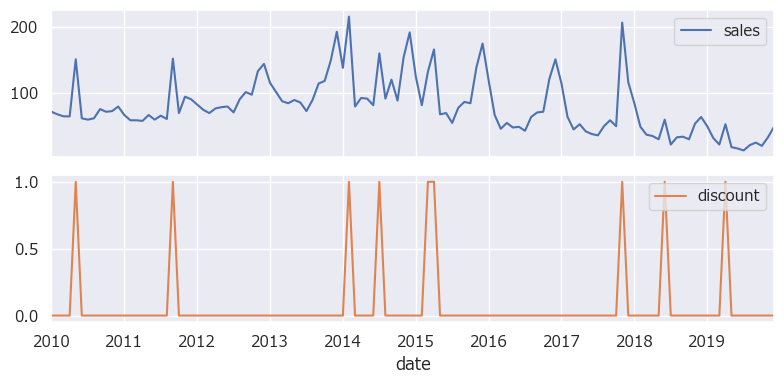

In [14]:
# 可視化
ts_sales_bj.plot(subplots=True)
plt.tight_layout()

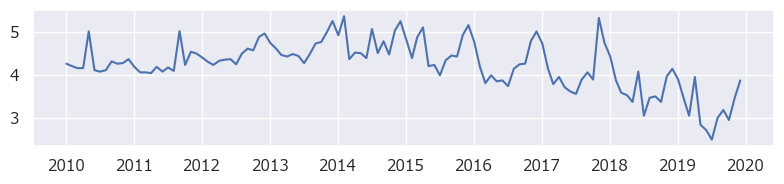

In [15]:
# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 2), tight_layout=True)

# 対数変換したグラフ
ax.plot(np.log(ts_sales_bj['sales']))

In [16]:
# 訓練データとテストデータに分割する
train = ts_sales_bj.loc['2010-01':'2018-12']
test =  ts_sales_bj.loc['2019-01':'2019-12']

#### SARIMAXモデルの推定

In [17]:
mod_sarimax = tsa.SARIMAX(
    np.log(train['sales']), exog=train['discount'],
    order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)
).fit(maxiter=5000, method='nm')

print(mod_sarimax.params)

Optimization terminated successfully.
         Current function value: -0.725494
         Iterations: 406
         Function evaluations: 634
discount    0.780721
ar.L1      -0.289926
ma.L1      -0.164008
ar.S.L12   -0.017217
ma.S.L12   -0.042015
sigma2      0.011220
dtype: float64


#### SARIMAXモデルによる予測

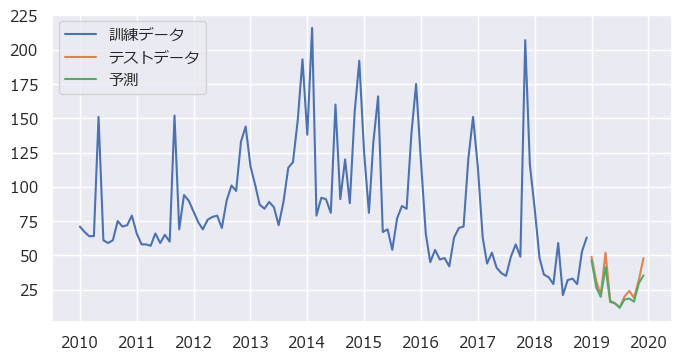

In [18]:
# 予測
pred_sarimax = mod_sarimax.forecast(
    12, exog = test['discount'].values.reshape(-1,1))

# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 4))

# 売り上げの折れ線グラフ
ax.plot(train['sales'], label='訓練データ')
ax.plot(test['sales'], label='テストデータ')

# 予測値の折れ線グラフ
ax.plot(np.exp(pred_sarimax), label='予測')

# 凡例
ax.legend()

#### 信頼区間付きの予測

In [19]:
# 信頼区間もあわせて計算
# forecast関数の代わりにget_forecast関数を使う
pred_ci = mod_sarimax.get_forecast(
    steps = 12,
    exog = test['discount'].values.reshape(-1,1) # 外生変数
)

print(pred_ci.summary_frame(alpha=0.05).head(3))

sales           mean   mean_se  mean_ci_lower  mean_ci_upper
2019-01-01  3.839755  0.105925       3.632145       4.047364
2019-02-01  3.273200  0.120689       3.036654       3.509746
2019-03-01  2.982692  0.140423       2.707468       3.257915


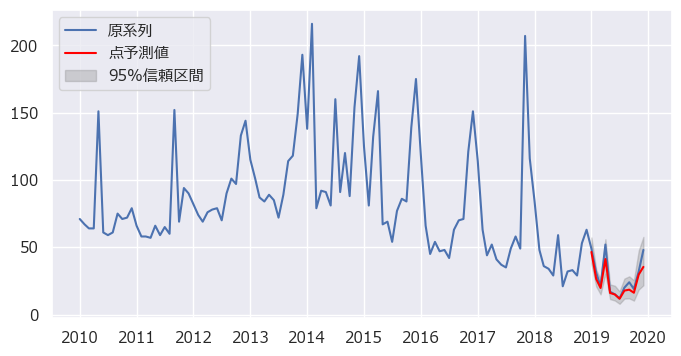

In [20]:
#  対数変換していたのを、元に戻した
conf_int_df_exp = pred_ci.summary_frame(alpha=0.05).apply(np.exp)

# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 4))

# 元データの図示
ax.plot(ts_sales_bj['sales'], label='原系列')

# 予測結果の図示
# 点予測値
ax.plot(conf_int_df_exp['mean'], color='red', label='点予測値')

# 信頼区間
ax.fill_between(
    test.index,                            # 横軸(時間軸)
    conf_int_df_exp['mean_ci_lower'],      # 下限値
    conf_int_df_exp['mean_ci_upper'],      # 上限値
    alpha=0.3,                             # 透過度
    color='gray',                          # 灰色にする
    label='95%信頼区間' 
)

# 凡例
ax.legend()